In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
# Load libraries

import pandas as pd
import numpy as np
import lda
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import os
import warnings 
import glob
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay, recall_score
from PIL import Image
import os
from pylab import *
from utils.utils import *
from sklearn.model_selection import train_test_split
import json
import lzma
import json
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import os
import warnings 
import glob
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay, recall_score
from PIL import Image
import os
from pylab import *
from utils.utils import * 
from sklearn.model_selection import train_test_split
import json
import lzma
import json

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

### Preprocessing

In [3]:
### Get comments and images from json files
data = get_df_comments('data/*/*json.xz')
### Resize images to avoid large time of preprocessing
get_resized_images('data/*',(512,512))


In [4]:
### Get cleaned path
data['path'] = data['files'].apply(get_path)

In [5]:
### Merge data with image path and comments
df_merged = merged_data(data, 'data/*/images/*')
df_merged.shape

(5516, 5)

In [6]:
### Download features using google vision api (already donwloaded and saved in data folder as features.csv)

Application_Credentials = '/Users/aladelca/Downloads/massive-acrobat-421018-1d8b6ce1a11a.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = Application_Credentials
try:
    df_features = pd.read_csv('features.csv')
except:
    df_features = get_features_images_path()


In [7]:
### Merge data with features
features = get_avg_features(df_features)
data_final = df_merged.merge(features, left_on = ['file_keys'], right_on = ['path'], how = 'left')
data_final = data_final.fillna(0)

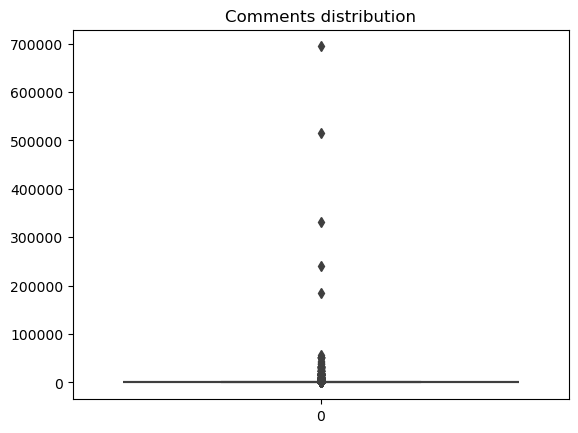

In [8]:
### Plot comments

sns.boxplot(data_final['comments'])
plt.title('Comments distribution')
plt.show()


In [ ]:
data_final['comments'].quantile(0.75)

### Task A

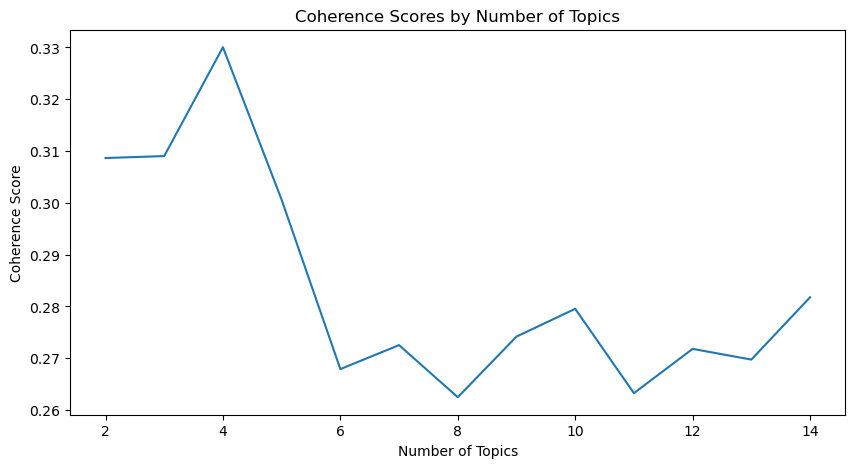

In [10]:
import gensim
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary

# Tokenize documents

texts = [list(data_final.columns)]
# Dictionary and corpus for LDA
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


coherence_values = []
topic_numbers = range(2, 15)  # from 2 to 15 topics

for num_topics in topic_numbers:
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(topic_numbers, coherence_values)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores by Number of Topics')
plt.show()

#### Comments

According to the coherence score, based on the proposed work from [Roder et al](https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf), and applied with `gensim`, the ideal number of topics that maximize the coherence is 4, so that's the number that it is going to be used for this exercise

In [13]:
NOT_CONSIDERED_COLUMNS = ['files', 'likes', 'path_x', 'name_keys', 'file_keys', 'path_y','target', 'comments']
data_features = data_final.loc[:,~ data_final.columns.isin(NOT_CONSIDERED_COLUMNS)]
data_features = pd.DataFrame(np.where(data_features>0,1,0), columns = data_features.columns)
lda = LatentDirichletAllocation(n_components=4, random_state=42)

#Train the model.
lda.fit(data_features)



#print the top 25 words in each topic
n = 25



for index, topic in enumerate(lda.components_):
    print(f'The top {n} words for topic #{index}')
    print([data_features.columns[i] for i in topic.argsort()[-n:]])
    


The top 25 words for topic #0
['furniture', 'houseplant', 'underpants', 'scarf', 'sandal', 'luggage_&_bags', 'tie', 'bag', 'picture_frame', 'couch', 'jeans', 'boot', 'jacket', 'window', 'necklace', 'handbag', 'sunglasses', 'glasses', 'coat', 'shoe', 'pants', 'footwear', 'clothing', 'outerwear', 'person']
The top 25 words for topic #1
['musical_instrument', 'bladeless_fan', 'dumbbell', 'laptop', 'microphone', 'chest_of_drawers', 'wine_glass', 'furniture', 'painting', 'christmas_tree', 'straw_hat', 'bed', 'chandelier', 'throw_pillow', 'lighting', 'television', 'miniskirt', 'poster', 'swimwear', 'pillow', 'brassiere', 'skirt', 'dress', 'clothing', 'person']
The top 25 words for topic #2
['cake', 'pizza', 'christmas_tree', 'coffee_cup', 'juice', 'teacup', 'fork', 'pastry', 'baked_goods', 'salad', 'fruit', 'spoon', 'dessert', 'building', 'dog', 'drink', 'tire', 'wheel', 'animal', 'table_top', 'plate', 'bowl', 'car', 'tableware', 'food']
The top 25 words for topic #3
['perfume', 'shoe', 'ove

#### Names for the topics

According to the results, the most suitable names for the topics would be:

* Topic 0: Clothing accesories 
* Topic 1: Desk/business articles
* Topic 2: Food and cook
* Topic 3: clothes and people

In [23]:
df_topic = pd.DataFrame(lda.fit_transform(data_features), columns = ['clothing_accesories', 'desk_business_articles', 'food_cook', 'clothes_people'])
df_topic['comments'] = data_final['comments']
df_topic['quantiles'] = pd.qcut(df_topic['comments'], 4, labels = ['low', 'medium', 'high', 'very_high'])


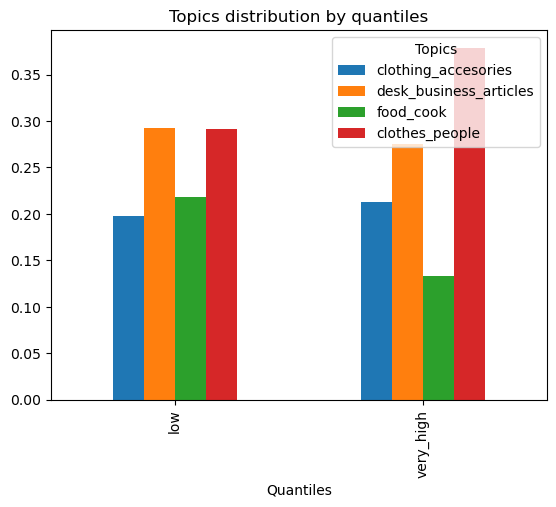

           clothing_accesories  desk_business_articles  food_cook  \
quantiles                                                           
low                   0.197335                0.292951   0.218635   
very_high             0.212844                0.275227   0.133103   

           clothes_people  
quantiles                  
low              0.291079  
very_high        0.378825  


In [43]:
df_analysis = df_topic.groupby(['quantiles']).agg({'clothing_accesories':'mean', 'desk_business_articles':'mean', 'food_cook':'mean', 'clothes_people':'mean'})
df_analysis = df_analysis.loc[['low','very_high'],:]
df_analysis.plot(kind = 'bar')
plt.title('Topics distribution by quantiles')
plt.xlabel('Quantiles')
plt.legend(title = 'Topics')
plt.show()

print(df_analysis)

In [51]:
data_features['comments'] = data_final['comments']
data_features['quantiles'] = pd.qcut(data_features['comments'], 4, labels = ['low', 'medium', 'high', 'very_high'])
data_features

,accordion,air_purifier,airplane,animal,baby_carrier,backpack,bag,bagged_packaged_goods,baked_goods,ball,balloon,banana,baseball_bat,baseball_glove,basket,basketball,bat,bean_bag,bed,beer,belt,bench,bicycle,bicycle_wheel,billiard_table,bird,bladeless_fan,boat,book,bookcase,boot,bottle,bottled_and_jarred_packaged_goods,bow_and_arrow,bowl,bowtie,box,boxed_packaged_goods,bracelet,brassiere,bread,bridge,bronze_sculpture,building,burrito,bus,bust,cabbage,cabinetry,cake,cake_stand,camel,camera,camera_lens,candle,canoe,car,cat,ceiling_fan,chair,chandelier,chest_of_drawers,chopsticks,christmas_tree,clock,clothing,coaster,coat,cocktail,coffee_cup,coffee_table,coffeemaker,container,cookie,couch,cowboy_hat,crown,cufflink,cutting_board,dessert,dog,doll,door,doughnut,dress,drink,dumbbell,eagle,earrings,egg,expresso_machine,fedora,figurine,fish,flag,flash,flower,flowerpot,food,football,football_helmet,footwear,fork,french_fries,fruit,frying_pan,furniture,giraffe,glasses,glove,goggles,golf_ball,greeting_card,guacamole,guitar,hamburger,handbag,hat,headphones,helmet,high_heels,home_appliance,horse,house,houseplant,ice_cream,jacket,jacuzzi,jeans,jet_ski,juice,kettle,kitchen_&_dining_room_table,kitchen_appliance,kitchen_appliance,knife,ladder,lamp,lantern,laptop,lemon,license_plate,light_fixture,lighthouse,lighting,loveseat,luggage_&_bags,magazine,microphone,microwave_oven,milk,miniskirt,mirror,mobile_phone,motorcycle,muffin,musical_instrument,necklace,nightstand,notebook,outerwear,overall,packaged_goods,painting,panda,pants,parking_meter,pasta,pastry,pen,perfume,person,picture_frame,pillow,pizza,plant,plate,poster,pressure_cooker,punching_bag,rabbit,raccoon,racket,refrigerator,remote_control,roller_skates,salad,sandal,sandwich,satchel,saucer,scarf,sculpture,shirt,shoe,shorts,skirt,slow_cooker,snowmobile,soap_dispenser,sock,sombrero,spoon,stool,straw_hat,strawberry,stroller,suit,suitcase,sun_hat,sunglasses,swimwear,table,table_top,tableware,taco,tart,teacup,television,tent,throw_pillow,tiara,tie,tiger,tin_can,tire,tomato,toothbrush,top,toy,toy_vehicle,treadmill,tripod,truck,trumpet,tubed_packaged_goods,umbrella,underpants,van,vase,vegetable,video_camera,waffle,wallet,waste_container,watch,wheel,wheelchair,whisk,whiteboard,window,wine_bottle,wine_glass,wok,woodpecker,comments,quantiles
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,low
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,low
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,low
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [58]:
df_elements = data_features.groupby(['quantiles']).agg('sum').T
print(df_elements.sort_values('low', ascending=False).iloc[1:25]['low'])
print(df_elements.sort_values('very_high', ascending=False).iloc[1:25]['very_high'])

person           898
clothing         620
top              336
food             166
tableware        146
pants            120
dress             94
outerwear         82
shoe              64
footwear          57
bowl              54
plate             50
glasses           36
jeans             33
hat               30
shorts            29
skirt             25
coat              24
car               20
table_top         18
drink             16
sunglasses        15
spoon             15
picture_frame     14
Name: low, dtype: int64
person        1112
clothing       769
top            495
pants          272
outerwear      137
dress          129
footwear        74
coat            68
glasses         62
shoe            57
hat             50
jeans           49
helmet          46
shorts          43
car             35
food            34
tableware       33
sunglasses      30
tire            16
tie             15
animal          15
wheel           13
skirt           13
brassiere       12
Name: very_high,

#### Comments and insights

We can see that the quantile with higher levels of engagements has more weight of clothes and people elements of that topic. On the other hand, the quantile with the lowest engagement has, on average, more presence of elements of desk and business articles topic. Another interesting fact is that the quantile with the highest engagement has a little presence of elements of food and cook, and the quantile with the lowest level of engagement has more presence of those elements. On average, both quantiles has the same average of weight for clothing and accessories elements.

Analyzing the specific elements present on the images with the lowest engagement, we can see that the most present elements are person, clothing, top, food and tableware; and even though the components person, clothing and top are shared for the quantiles with the higher and the lowest engagement, the difference comes with the other terms. For example, the quantile with the highest engagement has more photos with elements such as pants, outerwear and dress; which correlates with the findings at topic level.

### Task B

According to the findings, to get more engagement, the post in the instagram page should have photos with more presence of people wearing fancy clothes and accesories, and avoid food or cooking content. To validate this findings, I will use the CNN trained for the group assignment (it has been train with instagram data as well but retrained using comments instead of likes) and analyze the predictions

In [83]:
from keras.models import load_model
import pickle
columns = get_list('list_output.txt')
model = load_model('model.h5')
esc = pickle.load(open('scaler.pkl', 'rb'))
def load_and_prepare_images(df, column_name, image_size=(128, 128)):
    images = []
    for img_path in df[column_name]:
        img = Image.open(img_path)
        img = img.resize(image_size, Image.Resampling.LANCZOS)
        img = np.array(img)
        img = img.astype('float32') / 255.0  # Normalizar a [0, 1]
        images.append(img)
    return np.array(images)

def predict(path):
    source = path
    target = path+'/images'
    resize_images(source, target)
    features = pd.DataFrame()
    data_images = pd.DataFrame()
    data_images['path'] = glob.glob('demo/images/*.jpg')

    for i in glob.glob(f'{path}/images/*.jpg'):
        
        a = detect_objects(i)
        
        a['path'] = i
        features = pd.concat([features, a])
    
    b = features.pivot_table(
                                index=['path'],
                                columns='objects',
                                values='scores',
                                aggfunc='mean'
                            )
    b.columns = [i.lower().replace(' ','_') for i in b.columns]
    b = b.reset_index()
    b = b.fillna(0)
    NOT_CONSIDERED_COLUMNS = ['files', 'likes', 'path_x', 'name_keys', 'file_keys', 'path_y','target','path']
    c = pd.DataFrame(columns=columns)
    images = load_and_prepare_images(data_images, 'path')
    c[[i for i in b.columns if i not in NOT_CONSIDERED_COLUMNS]] = b[[i for i in b.columns if i not in NOT_CONSIDERED_COLUMNS]]
    c = c.fillna(0)
    c = esc.transform(c)
    data_images['preds'] =  model.predict([images, c])

    return data_images

glob.glob('demo/images/*.jpg')
predict('demo')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


,path,preds
0,demo/images/clothes.jpg,1358.122070
1,demo/images/food.jpg,937.849854
